In [1]:
import os 
import re
import random
import numpy as np
import pandas as pd 
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.random.set_seed(1)
random.seed(1)
np.random.seed(1)

In [3]:
base_path = os.curdir + "\\dataset-resized"

# Creating a dictionary of the 4 classes
categories={}
i = -1

for dirname, _, filenames in os.walk(base_path):
    for filename in filenames:
        categories[i] = dirname.split('\\')[-1]        
        break 
    
    i += 1

print("All Categories:")
for key, value in categories.items():
    print(key, "|",value)

All Categories:
0 | glass
1 | metal
2 | paper
3 | plastic


In [4]:
train_df = pd.read_csv("train.csv")
validate_df = pd.read_csv("validate.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df

,filename,category
0,glass\glass779.jpg,0
1,glass\glass763.jpg,0
2,glass\glass867.jpg,0
3,plastic\plastic523.jpg,3
4,paper\paper336.jpg,2
...,...,...
3195,plastic\plastic29.jpg,3
3196,paper\paper329.jpg,2
3197,metal\metal349.jpg,1
3198,glass\glass815.jpg,0


In [6]:
def load_images(df):
    X = []
    Y = []
    
    for index, row in df.iterrows():
        image_path = base_path + "\\" + row['filename']
        img = Image.open(image_path).convert("RGB")
        img = img.resize((100, 100))  # Resize to your desired input size
        img_array = np.array(img)  # Convert to NumPy array
        X.append(img_array/255.0)
        Y.append(row['category'])
        del img, img_array
    return np.array(X), np.array(Y)

In [7]:
trainX, trainY = load_images(train_df)
valX, valY = load_images(validate_df)
testX, testY = load_images(test_df)

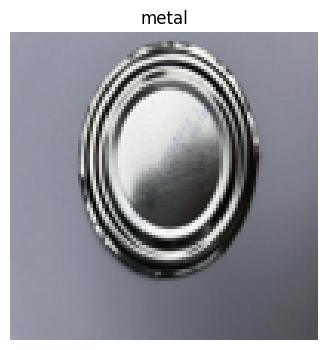

In [8]:
rand = random.randint(0,len(trainX))
plt.figure(figsize=(4,4))
plt.imshow(trainX[rand])
plt.title(categories[trainY[rand]])
plt.axis("off")
plt.show()

In [9]:
print("Shape of trainX =",trainX.shape)
print("Shape of trainY = ",trainY.shape)
print("Shape of valX   =",valX.shape)
print("Shape of valY   = ",valY.shape)
print("Shape of testX  =",testX.shape)
print("Shape of testY  = ",testY.shape)

Shape of trainX = (3200, 100, 100, 3)
Shape of trainY =  (3200,)
Shape of valX   = (560, 100, 100, 3)
Shape of valY   =  (560,)
Shape of testX  = (240, 100, 100, 3)
Shape of testY  =  (240,)


In [10]:
# One hot encoding the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

trainY = one_hot_encoder.fit_transform(trainY.reshape(-1,1))
valY = one_hot_encoder.fit_transform(valY.reshape(-1,1))
testY = one_hot_encoder.fit_transform(testY.reshape(-1,1))

trainY

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

## MLP Model

In [11]:
model = Sequential([    
    
    Flatten(input_shape=(100,100,3)),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(4, activation="softmax")
])

model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 512)               15360512  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 1

In [12]:
checkpoint = ModelCheckpoint("MLP_model", 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

In [13]:
history = model.fit(trainX, trainY, batch_size=72, epochs=200, validation_data=(valX, valY), callbacks=[checkpoint])

Epoch 1/200
40/45 [=========================>....] - ETA: 0s - loss: 5.4358 - accuracy: 0.2486
Epoch 1: val_accuracy improved from -inf to 0.29643, saving model to MLP_model
INFO:tensorflow:Assets written to: MLP_model\assets
45/45 [==============================] - 4s 54ms/step - loss: 5.0383 - accuracy: 0.2541 - val_loss: 1.4183 - val_accuracy: 0.2964
Epoch 2/200
41/45 [==========================>...] - ETA: 0s - loss: 1.4471 - accuracy: 0.3679
Epoch 2: val_accuracy improved from 0.29643 to 0.34464, saving model to MLP_model
INFO:tensorflow:Assets written to: MLP_model\assets
45/45 [==============================] - 2s 44ms/step - loss: 1.4328 - accuracy: 0.3716 - val_loss: 1.4311 - val_accuracy: 0.3446
Epoch 3/200
41/45 [==========================>...] - ETA: 0s - loss: 1.2605 - accuracy: 0.4312
Epoch 3: val_accuracy improved from 0.34464 to 0.46250, saving model to MLP_model
INFO:tensorflow:Assets written to: MLP_model\assets
45/45 [==============================] - 2s 43ms/step - 

INFO:tensorflow:Assets written to: MLP_model\assets
45/45 [==============================] - 2s 39ms/step - loss: 0.9800 - accuracy: 0.6059 - val_loss: 1.0517 - val_accuracy: 0.5696
Epoch 28/200
43/45 [===========================>..] - ETA: 0s - loss: 0.9530 - accuracy: 0.6095
Epoch 28: val_accuracy improved from 0.56964 to 0.57857, saving model to MLP_model
INFO:tensorflow:Assets written to: MLP_model\assets
45/45 [==============================] - 2s 41ms/step - loss: 0.9566 - accuracy: 0.6069 - val_loss: 1.0599 - val_accuracy: 0.5786
Epoch 29/200
43/45 [===========================>..] - ETA: 0s - loss: 0.9433 - accuracy: 0.6143
Epoch 29: val_accuracy did not improve from 0.57857
45/45 [==============================] - 1s 13ms/step - loss: 0.9426 - accuracy: 0.6147 - val_loss: 1.0967 - val_accuracy: 0.5554
Epoch 30/200
42/45 [===========================>..] - ETA: 0s - loss: 0.9538 - accuracy: 0.6200
Epoch 30: val_accuracy improved from 0.57857 to 0.59821, saving model to MLP_model


Epoch 56/200
44/45 [============================>.] - ETA: 0s - loss: 0.7530 - accuracy: 0.7004
Epoch 56: val_accuracy did not improve from 0.62857
45/45 [==============================] - 1s 12ms/step - loss: 0.7524 - accuracy: 0.7013 - val_loss: 1.1088 - val_accuracy: 0.5964
Epoch 57/200
43/45 [===========================>..] - ETA: 0s - loss: 0.6852 - accuracy: 0.7319
Epoch 57: val_accuracy did not improve from 0.62857
45/45 [==============================] - 1s 14ms/step - loss: 0.6865 - accuracy: 0.7306 - val_loss: 1.2353 - val_accuracy: 0.5768
Epoch 58/200
45/45 [==============================] - ETA: 0s - loss: 0.8040 - accuracy: 0.6922
Epoch 58: val_accuracy did not improve from 0.62857
45/45 [==============================] - 1s 14ms/step - loss: 0.8040 - accuracy: 0.6922 - val_loss: 1.0995 - val_accuracy: 0.6125
Epoch 59/200
44/45 [============================>.] - ETA: 0s - loss: 0.7599 - accuracy: 0.6970
Epoch 59: val_accuracy did not improve from 0.62857
45/45 [===========

Epoch 84/200
42/45 [===========================>..] - ETA: 0s - loss: 0.4077 - accuracy: 0.8485
Epoch 84: val_accuracy did not improve from 0.70714
45/45 [==============================] - 1s 13ms/step - loss: 0.4116 - accuracy: 0.8466 - val_loss: 1.0147 - val_accuracy: 0.6625
Epoch 85/200
42/45 [===========================>..] - ETA: 0s - loss: 0.4738 - accuracy: 0.8198
Epoch 85: val_accuracy did not improve from 0.70714
45/45 [==============================] - 1s 12ms/step - loss: 0.4715 - accuracy: 0.8206 - val_loss: 1.1166 - val_accuracy: 0.6321
Epoch 86/200
44/45 [============================>.] - ETA: 0s - loss: 0.4788 - accuracy: 0.8191
Epoch 86: val_accuracy did not improve from 0.70714
45/45 [==============================] - 1s 12ms/step - loss: 0.4801 - accuracy: 0.8184 - val_loss: 1.0132 - val_accuracy: 0.6107
Epoch 87/200
45/45 [==============================] - ETA: 0s - loss: 0.4796 - accuracy: 0.8156
Epoch 87: val_accuracy did not improve from 0.70714
45/45 [===========

42/45 [===========================>..] - ETA: 0s - loss: 0.3300 - accuracy: 0.8806
Epoch 113: val_accuracy did not improve from 0.72143
45/45 [==============================] - 1s 13ms/step - loss: 0.3341 - accuracy: 0.8788 - val_loss: 1.2064 - val_accuracy: 0.6821
Epoch 114/200
45/45 [==============================] - ETA: 0s - loss: 0.3612 - accuracy: 0.8584
Epoch 114: val_accuracy did not improve from 0.72143
45/45 [==============================] - 1s 13ms/step - loss: 0.3612 - accuracy: 0.8584 - val_loss: 1.4548 - val_accuracy: 0.6143
Epoch 115/200
43/45 [===========================>..] - ETA: 0s - loss: 0.3220 - accuracy: 0.8824
Epoch 115: val_accuracy did not improve from 0.72143
45/45 [==============================] - 1s 13ms/step - loss: 0.3201 - accuracy: 0.8847 - val_loss: 1.2027 - val_accuracy: 0.6786
Epoch 116/200
43/45 [===========================>..] - ETA: 0s - loss: 0.2953 - accuracy: 0.8860
Epoch 116: val_accuracy did not improve from 0.72143
45/45 [=================

Epoch 142/200
44/45 [============================>.] - ETA: 0s - loss: 0.1936 - accuracy: 0.9299
Epoch 142: val_accuracy did not improve from 0.73393
45/45 [==============================] - 1s 12ms/step - loss: 0.1941 - accuracy: 0.9297 - val_loss: 1.0666 - val_accuracy: 0.7339
Epoch 143/200
41/45 [==========================>...] - ETA: 0s - loss: 0.1945 - accuracy: 0.9292
Epoch 143: val_accuracy did not improve from 0.73393
45/45 [==============================] - 1s 13ms/step - loss: 0.1956 - accuracy: 0.9287 - val_loss: 1.4877 - val_accuracy: 0.6714
Epoch 144/200
42/45 [===========================>..] - ETA: 0s - loss: 0.3294 - accuracy: 0.8803
Epoch 144: val_accuracy improved from 0.73393 to 0.74286, saving model to MLP_model
INFO:tensorflow:Assets written to: MLP_model\assets
45/45 [==============================] - 2s 39ms/step - loss: 0.3255 - accuracy: 0.8816 - val_loss: 1.1651 - val_accuracy: 0.7429
Epoch 145/200
41/45 [==========================>...] - ETA: 0s - loss: 0.1701

45/45 [==============================] - 1s 12ms/step - loss: 0.3246 - accuracy: 0.8866 - val_loss: 1.0065 - val_accuracy: 0.7339
Epoch 171/200
43/45 [===========================>..] - ETA: 0s - loss: 0.1850 - accuracy: 0.9322
Epoch 171: val_accuracy improved from 0.75714 to 0.77500, saving model to MLP_model
INFO:tensorflow:Assets written to: MLP_model\assets
45/45 [==============================] - 2s 39ms/step - loss: 0.1897 - accuracy: 0.9300 - val_loss: 0.9382 - val_accuracy: 0.7750
Epoch 172/200
41/45 [==========================>...] - ETA: 0s - loss: 0.1836 - accuracy: 0.9336
Epoch 172: val_accuracy did not improve from 0.77500
45/45 [==============================] - 1s 13ms/step - loss: 0.1834 - accuracy: 0.9334 - val_loss: 1.2659 - val_accuracy: 0.7036
Epoch 173/200
45/45 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9356
Epoch 173: val_accuracy did not improve from 0.77500
45/45 [==============================] - 1s 14ms/step - loss: 0.1648 - accura

45/45 [==============================] - 1s 13ms/step - loss: 0.0600 - accuracy: 0.9828 - val_loss: 1.2536 - val_accuracy: 0.7429
Epoch 200/200
43/45 [===========================>..] - ETA: 0s - loss: 0.0573 - accuracy: 0.9813
Epoch 200: val_accuracy did not improve from 0.77500
45/45 [==============================] - 1s 12ms/step - loss: 0.0561 - accuracy: 0.9816 - val_loss: 1.3339 - val_accuracy: 0.7446


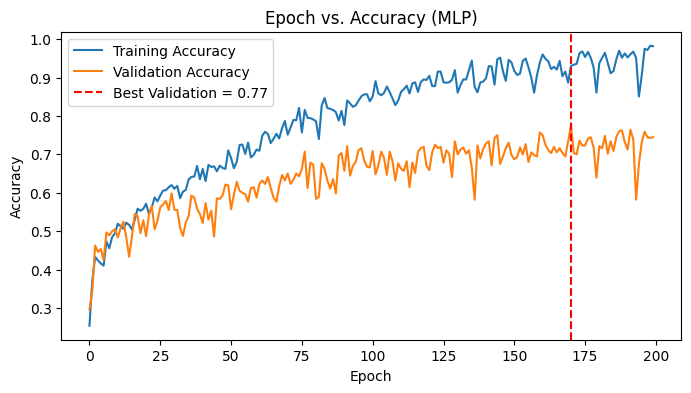

In [14]:
best = np.round(max(history.history['val_accuracy']), 2)
epoch = np.argmax(history.history['val_accuracy'])
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=epoch, color='r', linestyle='--', label=f'Best Validation = {best}')
plt.title('Epoch vs. Accuracy (MLP)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('CNN_model1\\CNN1_Epochs.png', dpi=300)
plt.show()

In [15]:
model = tf.keras.models.load_model('MLP_model')

In [16]:
model.evaluate(testX, testY)

8/8 [==============================] - 0s 4ms/step - loss: 1.1556 - accuracy: 0.7208


[1.155582070350647, 0.7208333611488342]

8/8 [==============================] - 0s 4ms/step


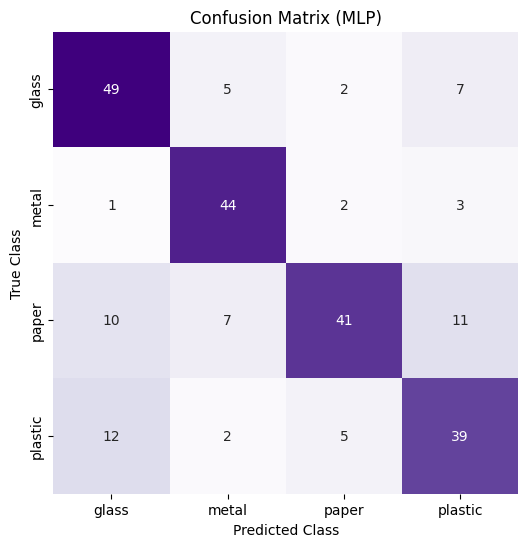

In [17]:
predY=model.predict(testX)
predY_classes=np.argmax(predY,axis=1)
trueY=np.argmax(testY,axis=1)

conf_mat=confusion_matrix(trueY, predY_classes)

f,ax=plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, cbar=False, cmap="Purples")
plt.title('Confusion Matrix (MLP)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
ax.set_xticklabels(categories.values())
ax.set_yticklabels(categories.values())
plt.savefig('MLP_model\\MLP_Confusion.png', dpi=300)
plt.show()